ADD DOCUMENTATION

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage, TextArea, HPacker
import time
from datetime import datetime
from PIL import Image
import numpy as np
import seaborn as sns
from matplotlib.colors import to_rgb

top_n_coins_input = 10 # Number of top coins to fetch, based on market cap, you can change this value
top_n_coins = min(50, max(1, top_n_coins_input)) # Limit to 50 coins, otherwise it will be too crowded and too slow, you can experiment with this value

LOGOS_DIRECTORY = "coin_logos" # Directory to save logos

if not os.path.exists(LOGOS_DIRECTORY):
    os.makedirs(LOGOS_DIRECTORY)

coin_logos = {}
coin_colors = {}
list_for_dataframe = []

In [2]:
url = "https://api.coingecko.com/api/v3/coins/markets" # CoinGecko public API, no API key required but rate-limited so higher amount of requests will take longer
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": top_n_coins,
    "page": 1,
}

response = requests.get(url, params=params)
top_coins = response.json()

print(f"Top {top_n_coins} cryptocurrencies by market cap:")
for i, coin in enumerate(top_coins):
    print(f"{i + 1}: {coin["name"]} ({coin["symbol"].upper()})")
    print(f"   Market Cap: ${coin["market_cap"]:,}")
    print(f"   Current Price: ${coin["current_price"]:,}")

Top 10 cryptocurrencies by market cap:
1: Bitcoin (BTC)
   Market Cap: $1,868,366,853,247
   Current Price: $94,002
2: Ethereum (ETH)
   Market Cap: $213,863,424,851
   Current Price: $1,773.33
3: Tether (USDT)
   Market Cap: $147,277,703,856
   Current Price: $1.0
4: XRP (XRP)
   Market Cap: $133,375,059,045
   Current Price: $2.28
5: BNB (BNB)
   Market Cap: $87,887,912,668
   Current Price: $602.17
6: Solana (SOL)
   Market Cap: $76,126,569,562
   Current Price: $147.03
7: USDC (USDC)
   Market Cap: $62,014,838,884
   Current Price: $0.999901
8: Dogecoin (DOGE)
   Market Cap: $26,311,698,694
   Current Price: $0.176329
9: Cardano (ADA)
   Market Cap: $25,164,128,752
   Current Price: $0.699703
10: TRON (TRX)
   Market Cap: $23,452,431,494
   Current Price: $0.247198


Error fetching data for BNB (BNB): 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/binancecoin/market_chart?vs_currency=usd&days=30&interval=daily
Retrying in 1 minute... (attempt 1/3)
Error fetching data for TRON (TRX): 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/tron/market_chart?vs_currency=usd&days=30&interval=daily
Retrying in 1 minute... (attempt 1/3)
Low volatility coin removed: Tether
Low volatility coin removed: USDC
Adjusting the color of XRP (XRP) to dark gray so it contrasts better with the background.


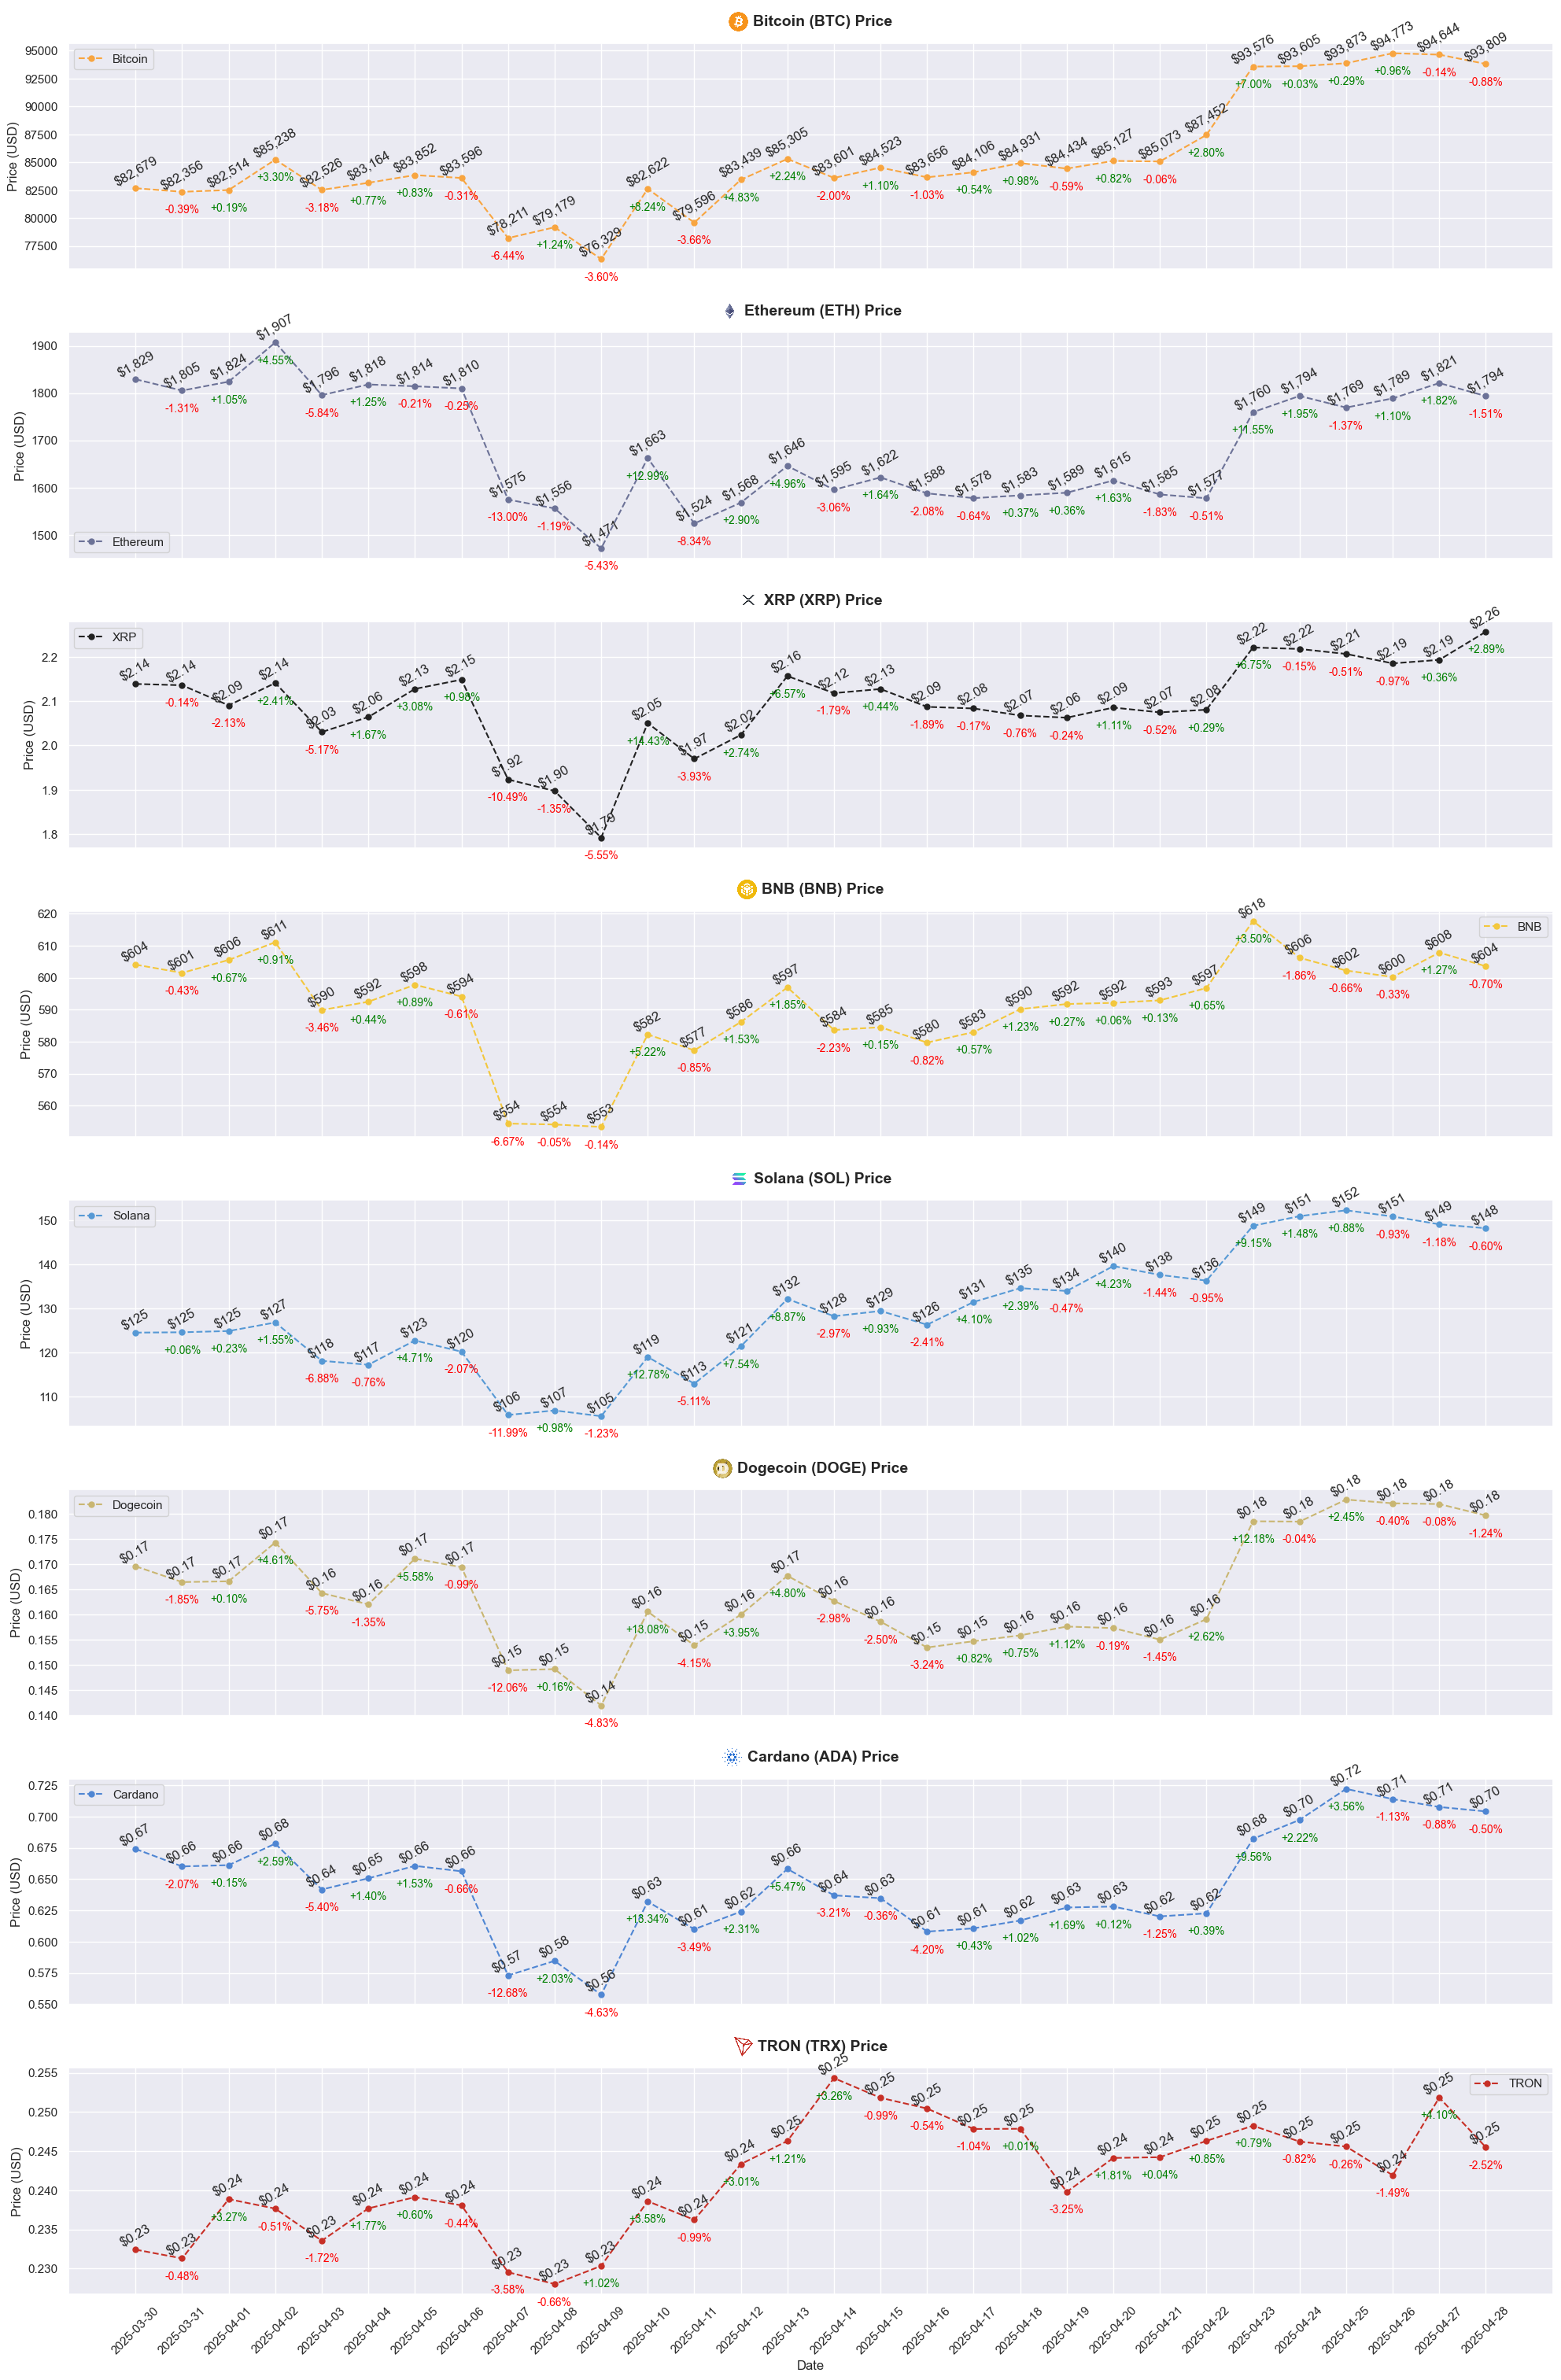

In [3]:
if top_n_coins > 20:
    print("Note: Loading more than 20 coins may take a while due to API limits.")

def get_dominant_color(image_path):
    img = Image.open(image_path).convert("RGBA")
    img = img.resize((50, 50))  # Resize to reduce noise
    img_np = np.array(img)
    
    # Remove fully transparent pixels
    pixels = img_np.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]  # Keep only non-transparent pixels

    rgb_pixels = pixels[:, :3]
    avg_color = tuple(np.mean(rgb_pixels, axis=0).astype(int))
    
    return tuple(c/255 for c in avg_color)  # Normalize to 0–1 for matplotlib

def get_logo(coin):
    logo_path = os.path.join(LOGOS_DIRECTORY, f"{coin["id"]}.png")
    if os.path.exists(logo_path):
        pass
    else:
        logo_data = requests.get(coin["image"]).content
        with open(logo_path, "wb") as f:
            f.write(logo_data)
    logo_img = mpimg.imread(logo_path)
    coin_logos[coin["name"]] = logo_img
    coin_colors[coin["name"]] = get_dominant_color(logo_path)

def luminance(r, g, b):
    # Convert to luminance
    a = [v/12.92 if v <= 0.03928 else ((v+0.055)/1.055)**2.4 for v in (r, g, b)]
    return 0.2126*a[0] + 0.7152*a[1] + 0.0722*a[2]

def contrast_ratio(rgb1, rgb2):
    L1 = luminance(*rgb1)
    L2 = luminance(*rgb2)
    return (max(L1, L2) + 0.05) / (min(L1, L2) + 0.05)

def ensure_contrast(color_hex, coin, symbol, background_hex="#e5e6fa", threshold=2):
    rgb1 = to_rgb(color_hex)
    rgb2 = to_rgb(background_hex)
    ratio = contrast_ratio(rgb1, rgb2)
    
    if ratio < threshold:
        print(f"Adjusting the color of {coin} ({symbol}) to dark gray so it contrasts better with the background.")
        return "#222222"  # fallback to dark gray
    return color_hex


for coin in top_coins:
    retries = 0
    
    get_logo(coin) # Fetch and save the logo
    
    params = {
        "vs_currency": "usd",
        "days": "30",
        "interval": "daily",
    }
    url = f"https://api.coingecko.com/api/v3/coins/{coin['id']}/market_chart"
    
    while retries < 3:
        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if "prices" not in data:
                raise ValueError(f"No 'prices' in response: {data}")

            seen_dates = set()

            for day in data["prices"]:
                timestamp, price = day
                date_str = datetime.fromtimestamp(timestamp / 1000).strftime("%Y-%m-%d")
                if date_str not in seen_dates:
                    list_for_dataframe.append({
                        "name": coin["name"],
                        "symbol": coin["symbol"].upper(),
                        "date": date_str,
                        "price": price,
                    })
                    seen_dates.add(date_str)
            break
        except Exception as e:
            retries += 1
            print(f"Error fetching data for {coin["name"]} ({coin["symbol"].upper()}): {e}")
            if retries < 3:
                print(f"Retrying in 1 minute... (attempt {retries}/3)")
                time.sleep(60)
            else:
                print(f"Failed to fetch data for {coin["name"]} ({coin["symbol"].upper()}) after 3 attempts.")
    
df = pd.DataFrame(list_for_dataframe)

sns.set_theme()

grouped = df.groupby("name")["price"]
mean_prices = grouped.mean()
std_prices = grouped.std()

# Calculate coefficient of variation (CV)
cv = std_prices / mean_prices

low_volatility_names = cv[cv < 0.01].index
df = df[~df["name"].isin(low_volatility_names)]
for name in low_volatility_names:
    print(f"Low volatility coin removed: {name}")
    
unique_names = df["name"].unique()
fig, axes = plt.subplots(len(unique_names), 1, figsize=(20, 4 * len(unique_names)), sharex=True)

if len(unique_names) == 1:
    axes = [axes]

for ax, name in zip(axes, unique_names):
    group = df[df["name"] == name].copy()
    group = group.sort_values("date")
    group["pct_change"] = group["price"].pct_change() * 100
    
    symbol = group["symbol"].iloc[0]
    
    dominant_color = coin_colors.get(name, "blue")
    line_color = ensure_contrast(dominant_color, name, symbol, threshold=1.3)

    ax.plot(group["date"], group["price"], "o--", label=name, color=line_color, linewidth=1.5, markersize=5)

    for x, y, pct in zip(group["date"], group["price"], group["pct_change"]):
        if y > 50:
             price_label = f"${y:,.0f}"
        else:
             price_label = f"${y:,.2f}"
        ax.text(x, y, price_label, fontsize=12, ha="center", va="bottom", rotation=30)

        if not pd.isna(pct):
            pct_label = f"{pct:+.2f}%"
            text_color = "green" if pct > 0 else "red" if pct < 0 else "gray"
            ax.text(x, y, f"\n{pct_label}", fontsize=10, color=text_color,
                     ha="center", va="top", rotation=0)

    title_text = f"{name} ({symbol}) Price"

    if name in coin_logos:
        try:
            logo_img = coin_logos[name]
            imagebox = OffsetImage(logo_img, zoom=0.07)
            textbox = TextArea(title_text, textprops=dict(fontsize=14, weight="bold"))

            vbox = HPacker(children=[imagebox, textbox], align="center", pad=0, sep=5)

            ab = AnnotationBbox(
                vbox,
                (0.5, 1.05),
                xycoords="axes fraction",
                frameon=False,
                box_alignment=(0.5, 0)
            )
            ax.add_artist(ab)
        except Exception as e:
            print(f"Error adding logo/title for {name} ({symbol}): {e}. Using text title.")
            ax.set_title(title_text, fontsize=14, weight="bold", pad=20)
    else:
        print(f"Logo not found for {name} ({symbol}). Using text title.")
        ax.set_title(title_text, fontsize=14, weight="bold", pad=20)

    ax.set_ylabel("Price (USD)")
    ax.legend()
    ax.grid(True)

plt.xticks(rotation=45)
plt.xlabel("Date")

plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.show()